In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import time
from configs import TIMEZONE, LOG_FILE_NAME, set_logger
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import GetAssetsRequest
from alpaca.data.historical import StockHistoricalDataClient, CryptoHistoricalDataClient
from alpaca.data.requests import StockLatestQuoteRequest, StockBarsRequest, CryptoLatestQuoteRequest
from alpaca.data.requests import CryptoBarsRequest
from alpaca.trading.models import Order
from alpaca.data.timeframe import TimeFrame
from my_secrets import ALPACA_API_BASE_URL, PAPER_API_ID, PAPER_SECRET_KEY
import logging
import plotly.express as px
import plotly.graph_objects as go
set_logger()

In [12]:
import torch
import torch.nn as nn

In [13]:
from Trade_Class import Stock_Trader, Crypto_Trader
from Market_Monitor import Market_Monitor
from ALGO_crossover import bars_df_filter_dates, add_sma_columns, add_sma_crossovers

In [14]:
stock_trader = Stock_Trader(PAPER_API_ID, PAPER_SECRET_KEY, paper=True)
monitor = Market_Monitor(stock_trader.trading_client, TIMEZONE)

In [15]:
start = datetime(year=2015, month=1, day=1, hour=0, minute=0, second=0)
end = datetime(year=2023, month=2, day=1, hour=0, minute=0, second=0)
bars_df = stock_trader.get_bars('AAPL', start=start, end=end, time_resolution='day')
bars_df.reset_index(inplace=True)
bars_df.sort_values(by=['timestamp'], ascending=True, inplace=True)
print(bars_df.shape)
display(bars_df.head())

(1804, 9)


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,AAPL,2015-12-01 05:00:00+00:00,118.75,118.81,116.86,117.34,34852374.0,187129.0,117.756760
1,AAPL,2015-12-02 05:00:00+00:00,117.05,118.11,116.08,116.28,33385643.0,180616.0,117.151198
2,AAPL,2015-12-03 05:00:00+00:00,116.55,116.79,114.22,115.20,41560785.0,245330.0,115.434888
3,AAPL,2015-12-04 05:00:00+00:00,115.29,119.25,115.11,119.03,57776977.0,307788.0,118.187290
4,AAPL,2015-12-07 05:00:00+00:00,118.98,119.86,117.81,118.28,32080754.0,190809.0,118.509111


In [16]:
def prep_RNN_data(bars_df, col='close', test_pct=0.25, scaler=None):
    array = bars_df[col].values
    if scaler!=None:
        array = scaler.fit_transform(array.reshape(-1, 1))
    train_size = len(array) - int(len(array)*test_pct)
    train_array = array[:train_size]
    test_array = array[train_size:]
    return train_array, test_array

In [17]:
SEQUENCE_LENGTH = 50
NUM_EXAMPLES = 949
NUM_LAYERS = 2
HIDDEN_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TEST_PCT = 0.25
BATCH_SIZE = 32
EPOCHS = 100

In [18]:
train_array, test_array = prep_RNN_data(bars_df, col='close', test_pct=TEST_PCT, scaler=MinMaxScaler())
len(train_array), len(test_array)

(1353, 451)

In [19]:
class RNNDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        """
        Takes in `data` which is a numpy array and `seq_len` which is an int.
        """
        self.data = data
        self.seq_len = seq_len
        self.data = torch.from_numpy(data).float()

    def __len__(self):
        return (len(self.data) - self.seq_len) - 1
    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len]

In [20]:
train_dataset = RNNDataset(train_array, SEQUENCE_LENGTH)
test_dataset = RNNDataset(test_array, SEQUENCE_LENGTH)

len(train_dataset), len(test_dataset)

(1302, 400)

https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch

In [21]:
x, y = train_dataset[0]
x.shape, y.shape

(torch.Size([50, 1]), torch.Size([1]))

In [22]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
train_loader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, drop_last=True, shuffle=True)
train_loader = DeviceDataLoader(train_loader, DEVICE)
test_loader = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, drop_last=True)
test_loader = DeviceDataLoader(test_loader, DEVICE)

In [24]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        out, hn = self.rnn(x) #by not providing hidden state it is automatically set to 0's

        # out.size() --> batch_size, sequence_length, hidden_size --> torch.Size([32, 50, 100])
        # out[:, -1, :] --> batch_size, hidden_size -->torch.Size([32, 100]) --> just want last time step! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> batch_size, output_dim --> 100, 1
        return out

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        out, (hn, cn) = self.lstm(x) #by not providing hidden state and cell state they are automatically set to 0's

        # out.size() --> batch_size, sequence_length, hidden_size --> torch.Size([32, 50, 100])
        # out[:, -1, :] --> batch_size, hidden_size -->torch.Size([32, 100]) --> just want last time step! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> batch_size, output_dim --> 100, 1
        return out
    


In [26]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        out, hn = self.gru(x) #by not providing hidden state it is automatically set to 0's

        # out.size() --> batch_size, sequence_length, hidden_size --> torch.Size([32, 50, 100])
        # out[:, -1, :] --> batch_size, hidden_size -->torch.Size([32, 100]) --> just want last time step! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> batch_size, output_dim --> 100, 1
        return out

In [27]:
rnn_model = RNN(input_dim=1, hidden_dim=100, output_dim=1, num_layers=2)
rnn_model.to(DEVICE)
lstm_model = RNN(input_dim=1, hidden_dim=100, output_dim=1, num_layers=2)
lstm_model.to(DEVICE)
gru_model = GRU(input_dim=1, hidden_dim=100, output_dim=1, num_layers=2)
gru_model.to(DEVICE)

loss_fn = torch.nn.MSELoss()

rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

In [28]:
def fit_model(num_epochs: int, model: nn.Module, train_loader: torch.utils.data.DataLoader, test_loader: torch.utils.data.DataLoader, loss_fn, optimizer: torch.optim):
    training_losses = []
    testing_losses = []
    
    for e in range(num_epochs):
        # Forward pass
        train_losses = []
        model.train()
        for batch in train_loader:
            X_train, y_train = batch
            y_train_pred = model(X_train)
            loss = loss_fn(y_train_pred, y_train)
            train_losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        test_losses = []
        with torch.inference_mode():
            model.eval()
            for batch in test_loader:
                X_test, y_test = batch
                y_test_pred = model(X_test)
                loss = loss_fn(y_test_pred, y_test)
                test_losses.append(loss)

        training_losses.append(torch.mean(torch.FloatTensor(train_losses)))
        testing_losses.append(torch.mean(torch.FloatTensor(test_losses)))
        if e % 5 == 0:
            print(f"Epoch {e}  \tTrain MSE: {torch.mean(torch.FloatTensor(train_losses)):.5f}\tTest MSE: {torch.mean(torch.FloatTensor(test_losses)):.5f}")
    return training_losses, testing_losses

In [29]:
rnn_training_losses, rnn_testing_losses = fit_model(100, rnn_model, train_loader, test_loader, loss_fn, rnn_optimizer)

Epoch 0  	Train MSE: 0.02063	Test MSE: 0.00506
Epoch 5  	Train MSE: 0.00126	Test MSE: 0.00008
Epoch 10  	Train MSE: 0.00099	Test MSE: 0.00006
Epoch 15  	Train MSE: 0.00100	Test MSE: 0.00010
Epoch 20  	Train MSE: 0.00091	Test MSE: 0.00021
Epoch 25  	Train MSE: 0.00108	Test MSE: 0.00012
Epoch 30  	Train MSE: 0.00095	Test MSE: 0.00008
Epoch 35  	Train MSE: 0.00012	Test MSE: 0.00007
Epoch 40  	Train MSE: 0.00094	Test MSE: 0.00006
Epoch 45  	Train MSE: 0.00084	Test MSE: 0.00018
Epoch 50  	Train MSE: 0.00092	Test MSE: 0.00008
Epoch 55  	Train MSE: 0.00108	Test MSE: 0.00020
Epoch 60  	Train MSE: 0.00110	Test MSE: 0.00005
Epoch 65  	Train MSE: 0.00087	Test MSE: 0.00006
Epoch 70  	Train MSE: 0.00093	Test MSE: 0.00026
Epoch 75  	Train MSE: 0.00075	Test MSE: 0.00028
Epoch 80  	Train MSE: 0.00091	Test MSE: 0.00011
Epoch 85  	Train MSE: 0.00097	Test MSE: 0.00022
Epoch 90  	Train MSE: 0.00111	Test MSE: 0.00025
Epoch 95  	Train MSE: 0.00087	Test MSE: 0.00006


In [30]:
lstm_training_losses, lstm_testing_losses = fit_model(100, lstm_model, train_loader, test_loader, loss_fn, lstm_optimizer)

Epoch 0  	Train MSE: 0.01832	Test MSE: 0.00052
Epoch 5  	Train MSE: 0.00116	Test MSE: 0.00035
Epoch 10  	Train MSE: 0.00084	Test MSE: 0.00026
Epoch 15  	Train MSE: 0.00078	Test MSE: 0.00006
Epoch 20  	Train MSE: 0.00088	Test MSE: 0.00013
Epoch 25  	Train MSE: 0.00088	Test MSE: 0.00010
Epoch 30  	Train MSE: 0.00103	Test MSE: 0.00021
Epoch 35  	Train MSE: 0.00097	Test MSE: 0.00009
Epoch 40  	Train MSE: 0.00094	Test MSE: 0.00007
Epoch 45  	Train MSE: 0.00098	Test MSE: 0.00005
Epoch 50  	Train MSE: 0.00092	Test MSE: 0.00011
Epoch 55  	Train MSE: 0.00091	Test MSE: 0.00017
Epoch 60  	Train MSE: 0.00080	Test MSE: 0.00013
Epoch 65  	Train MSE: 0.00085	Test MSE: 0.00007
Epoch 70  	Train MSE: 0.00016	Test MSE: 0.00008
Epoch 75  	Train MSE: 0.00083	Test MSE: 0.00053
Epoch 80  	Train MSE: 0.00085	Test MSE: 0.00009
Epoch 85  	Train MSE: 0.00088	Test MSE: 0.00009
Epoch 90  	Train MSE: 0.00082	Test MSE: 0.00008
Epoch 95  	Train MSE: 0.00085	Test MSE: 0.00008


In [31]:
gru_training_losses, gru_testing_losses = fit_model(100, gru_model, train_loader, test_loader, loss_fn, gru_optimizer)

Epoch 0  	Train MSE: 0.01813	Test MSE: 0.00020
Epoch 5  	Train MSE: 0.00119	Test MSE: 0.00014
Epoch 10  	Train MSE: 0.00111	Test MSE: 0.00026
Epoch 15  	Train MSE: 0.00095	Test MSE: 0.00017
Epoch 20  	Train MSE: 0.00085	Test MSE: 0.00015
Epoch 25  	Train MSE: 0.00112	Test MSE: 0.00015
Epoch 30  	Train MSE: 0.00085	Test MSE: 0.00009
Epoch 35  	Train MSE: 0.00091	Test MSE: 0.00010
Epoch 40  	Train MSE: 0.00080	Test MSE: 0.00051
Epoch 45  	Train MSE: 0.00082	Test MSE: 0.00008
Epoch 50  	Train MSE: 0.00077	Test MSE: 0.00011
Epoch 55  	Train MSE: 0.00085	Test MSE: 0.00011
Epoch 60  	Train MSE: 0.00075	Test MSE: 0.00012
Epoch 65  	Train MSE: 0.00083	Test MSE: 0.00011
Epoch 70  	Train MSE: 0.00082	Test MSE: 0.00006
Epoch 75  	Train MSE: 0.00077	Test MSE: 0.00039
Epoch 80  	Train MSE: 0.00080	Test MSE: 0.00016
Epoch 85  	Train MSE: 0.00083	Test MSE: 0.00009
Epoch 90  	Train MSE: 0.00084	Test MSE: 0.00009
Epoch 95  	Train MSE: 0.00093	Test MSE: 0.00012


In [32]:
def plot_losses(num_epochs, training_losses, testing_losses, title_addition=''):
    training_losses = torch.FloatTensor(training_losses).cpu().numpy()
    testing_losses = torch.FloatTensor(testing_losses).cpu().numpy()

    fig, ax = plt.subplots()
    ax.plot(np.array(range(num_epochs)), training_losses, c='blue', label='Test Loss')
    ax.plot(np.array(range(num_epochs)), testing_losses, c='orange', label='Train Loss')

    ax.set_title(f"Training Vs Testing Losses\n{title_addition}")

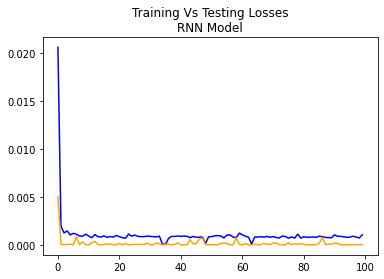

In [33]:
plot_losses(100, rnn_training_losses, rnn_testing_losses, title_addition='RNN Model')

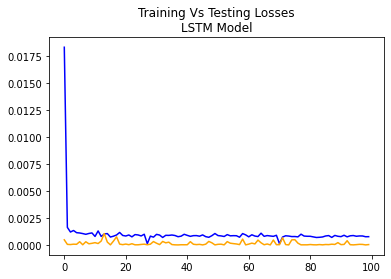

In [34]:
plot_losses(100, lstm_training_losses, lstm_testing_losses, title_addition='LSTM Model')

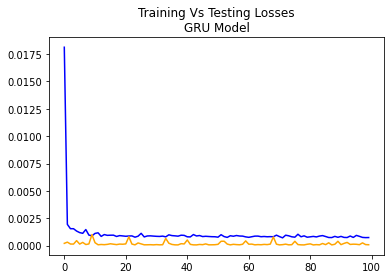

In [35]:
plot_losses(100, gru_training_losses, gru_testing_losses, title_addition='GRU Model')

In [36]:
(100, rnn_model, train_loader, test_loader, loss_fn, rnn_optimizer)

(100,
 RNN(
   (rnn): RNN(1, 100, num_layers=2, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 MSELoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [37]:
def rnn_type_predict(model: nn.Module, array: np.array, device):
    """
    Predicts the next value in a sequence of values. 

    Parameters:
    -----------
    `model` : The pytorch model to predict the next value in the sequence. 
    The model must be Recurrent in nature. Most likely meaning either RNN, LSTM, or GRU.
    `array` : The sequence of values to find the next value of.
    `device` : Either a string or pytorch device.
    """
    model.eval()
    array = torch.from_numpy(array).float()
    array = torch.unsqueeze(array, 0) #unsqueeze once for batch size of 1
    array = array.to(device)
    with torch.inference_mode():
        pred = model(array)

    return float(pred.squeeze().cpu())

In [38]:
def visualize_predictions(model, train_array, test_array, device):
    x = np.arange((len(train_array)+len(test_array)))

    y = np.append(np.squeeze(train_array), np.squeeze(test_array))
    

    preds = []
    for i in range(50, len(test_array)-1):
        preds.append(rnn_type_predict(model, test_array[i-50:i], device))
    
    preds = np.array(preds)

    x_preds = np.arange(start=len(train_array)+50, stop=len(y)-1)

    #print(preds.shape, x_preds.shape)

    fig, ax = plt.subplots()

    ax.plot(x, y)
    ax.plot(x_preds, preds, c='orange', label='predictions')
    plt.show()
    return ax

In [95]:
def visualize_chained_predictions(model, train_array, test_array, device):
    x = np.arange((len(train_array)+len(test_array)))

    y = np.append(np.squeeze(train_array), np.squeeze(test_array))
    

    preds = test_array[:51]
    for i in range(50, len(test_array)-1):

        pred = rnn_type_predict(model, preds[i-50:i], device)
        preds = np.expand_dims(np.append(preds, np.array(pred).reshape(1)), 1)

    

    preds = np.squeeze(preds[51:])
    x_preds = np.arange(start=len(train_array)+50, stop=len(y)-1)

    #print(preds.shape, x_preds.shape)

    fig, ax = plt.subplots()

    ax.plot(x, y)
    ax.plot(x_preds, preds, c='orange', label='predictions')
    plt.show()
    return ax

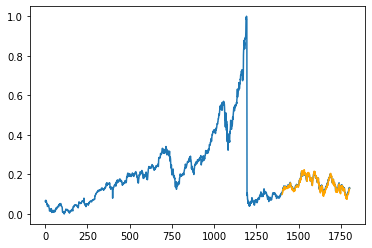

<Axes: >

In [39]:
visualize_predictions(rnn_model, train_array, test_array, DEVICE)

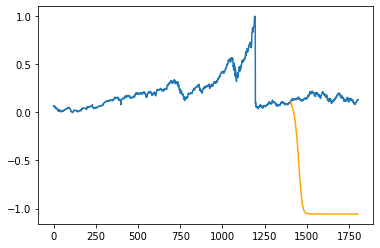

<Axes: >

In [96]:
visualize_chained_predictions(rnn_model, train_array, test_array, DEVICE)

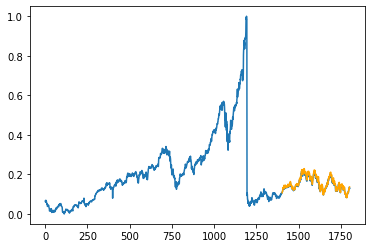

<Axes: >

In [97]:
visualize_predictions(lstm_model, train_array, test_array, DEVICE)

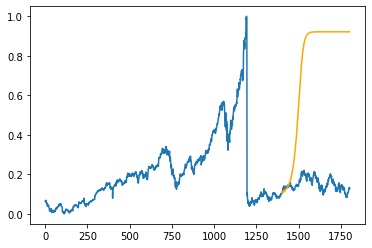

<Axes: >

In [98]:
visualize_chained_predictions(lstm_model, train_array, test_array, DEVICE)

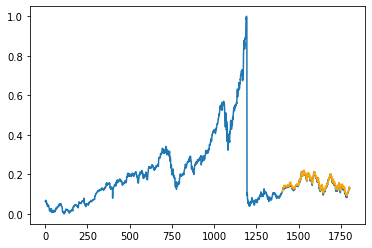

<Axes: >

In [99]:
visualize_predictions(gru_model, train_array, test_array, DEVICE)

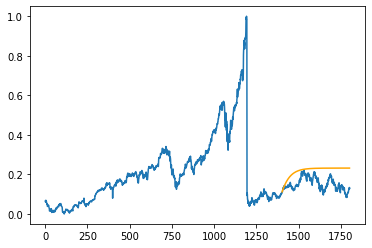

<Axes: >

In [100]:
visualize_chained_predictions(gru_model, train_array, test_array, DEVICE)